<a href="https://colab.research.google.com/github/DrAlexSanz/spacy/blob/master/Spacy_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large-scale data analysis with spaCy

https://course.spacy.io/chapter2

In this chapter, you'll use your new skills to extract specific information from large volumes of text. You''ll learn how to make the most of spaCy's data structures, and how to effectively combine statistical and rule-based approaches for text analysis.

In [1]:
#!pip install spacy
import spacy

# 1. Data Structures (1): Vocab, Lexemes and StringStore

Now that you've had some real experience using spaCy's objects, it's time for you to learn more about what's actually going on under spaCy's hood.

In this lesson, we'll take a look at the shared vocabulary and how spaCy deals with strings.

Shared Vocab and string store
SpaCy stores all shared data in a vocabulary, the Vocab.

This includes words, but also the labels schemes for tags and entities.

To save memory, all strings are encoded to hash IDs. If a word occurs more than once, we don't need to save it every time.

Instead, spaCy uses a hash function to generate an ID and stores the string only once in the string store. The string store is available as `nlp.vocab.strings`.

It's a lookup table that works in both directions. You can look up a string and get its hash, and look up a hash to get its string value. Internally, spaCy only communicates in hash IDs.

Hash IDs can't be reversed, though. If a word in not in the vocabulary, there's no way to get its string. That's why we always need to pass around the shared vocab.

In [3]:
nlp = spacy.load("en_core_web_sm")
print(len(nlp.vocab.strings))

1139


In [4]:
coffe_hash = nlp.vocab.strings['coffee']
print(coffe_hash)

3197928453018144401


In [5]:
# This should give an error if I run it
#coffee_string = nlp.vocab.strings[coffe_hash]
#print(coffee_string)

KeyError: ignored

To get the hash for a string, we can look it up in nlp dot vocab dot strings.

To get the string representation of a hash, we can look up the hash.

A Doc object also exposes its vocab and strings.

In [6]:
doc = nlp("I love coffee")
print('hash value:', nlp.vocab.strings['coffee'])
print('string value:', nlp.vocab.strings[3197928453018144401])

hash value: 3197928453018144401
string value: coffee


## Lexemes: entries in the vocabulary
Lexemes are context-independent entries in the vocabulary.

You can get a lexeme by looking up a string or a hash ID in the vocab.

Lexemes expose attributes, just like tokens.

They hold context-independent information about a word, like the text, or whether the the word consists of alphanumeric characters.

Lexemes don't have part-of-speech tags, dependencies or entity labels. Those depend on the context.

In [10]:
doc = nlp("I love coffee")

for word in doc:
  lexeme = nlp.vocab[str(word)]
  print(lexeme.text, lexeme.orth, lexeme.is_alpha)

I 4690420944186131903 True
love 3702023516439754181 True
coffee 3197928453018144401 True


# 2. String to hashes
## Part 1

* Look up the string “cat” in nlp.vocab.strings to get the hash.
* Look up the hash to get back the string.

In [11]:
doc = nlp("I have a cat")

cat_hash = nlp.vocab.strings["cat"]
print(cat_hash)

cat_string = nlp.vocab.strings[cat_hash] # cat_hash is an int
print(cat_string)

5439657043933447811
cat


# 3. Data Structures(2)
Now that you know all about the vocabulary and string store, we can take a look at the most important data structure: the Doc, and its views Token and Span.

## The Doc object
The Doc is one of the central data structures in spaCy. It's created automatically when you process a text with the nlp object. But you can also instantiate the class manually.

After creating the nlp object, we can import the Doc class from spacy dot tokens.

Here we're creating a Doc from three words. The spaces are a list of boolean values indicating whether the word is followed by a space. Every token includes that information – even the last one!

The Doc class takes three arguments: the shared vocab, the words and the spaces.

In [12]:
# Create an nlp object
from spacy.lang.en import English
nlp = English()

# Import the Doc class
from spacy.tokens import Doc

# The words and spaces to create the doc from
words = ['Hello', 'world', '!']
spaces = [True, False, False]

# Create a doc manually
doc = Doc(nlp.vocab, words=words, spaces=spaces)

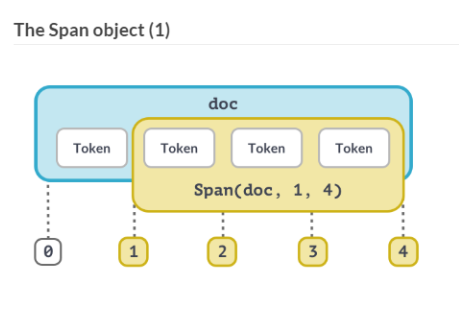

A Span is a slice of a Doc consisting of one or more tokens.

The Span takes at least three arguments: the doc it refers to, and the start and end index of the span. Remember that the **end index is exclusive!**

To create a Span manually, we can also import the class from spacy dot tokens. We can then instantiate it with the doc and the span's start and end index.

To add an entity label to the span, we first need to look up the string in the string store. We can then provide it to the span as the label argument.

The doc dot ents are writable, so we can add entities manually by overwriting it with a list of spans.

In [15]:
from spacy.tokens import Doc, Span

# The words and spaces to create the doc from
words = ['Hello', 'world', '!']
spaces = [True, False, False]

# Create a doc manually
doc = Doc(nlp.vocab, words=words, spaces=spaces)

print(doc.ents)

# Create a span manually
span = Span(doc, 0, 2)

# Create a span with a label
span_with_label = Span(doc, 0, 2, label="GREETING")

# Add span to the doc.ents
doc.ents = [span_with_label]
print(doc.ents)

()
(Hello world,)


A few tips and tricks before we get started:

* The Doc and Span are very powerful and optimized for performance. They give you access to all references and relationships of the words and sentences.

* If your application needs to output strings, make sure to convert the doc as late as possible. If you do it too early, you'll lose all relationships between the tokens.

* To keep things consistent, try to use built-in token attributes wherever possible. For example, token dot i for the token index.

* Also, don't forget to always pass in the shared vocab!

# 3. Data structures and best practices
The code in this example is trying to analyze a text and collect all proper nouns that are followed by a verb.

## Part 1
Why is the code bad?

In [21]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("Berlin is a nice city")

# Get all tokens and part-of-speech tags
token_texts = [token.text for token in doc]
pos_tags = [token.pos_ for token in doc]

for index, pos in enumerate(pos_tags):
    # Check if the current token is a proper noun
    if pos == "PROPN":
        # Check if the next token is a verb
        if pos_tags[index + 1] == "VERB":
            result = token_texts[index]
            print("Found proper noun before a verb:", result)



## Answer:

It only uses lists of strings instead of native token attributes. This is often less efficient, and can't express complex relationships.

Always convert the results to strings as late as possible, and try to use native token attributes to keep things consistent.

## Part 2
* Rewrite the code to use the native token attributes instead of lists of token_texts and pos_tags.
* Loop over each token in the doc and check the token.pos_ attribute.
* Use `doc[token.i + 1]` to check for the next token and its .pos_ attribute.
* If a proper noun before a verb is found, print its token.text.

In [22]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("Berlin is a nice city")

# Iterate over the tokens
for token in doc:
    # Check if the current token is a proper noun
    if token.pos_ == "PROPN":
        # Check if the next token is a verb
        if doc[token.i + 1].pos_ == "VERB":
            print("Found proper noun before a verb:", token.text)

# 4. Word vectors and semantic similarities

In this lesson, you'll learn how to use spaCy to predict how similar documents, spans or tokens are to each other.

You'll also learn about how to use word vectors and how to take advantage of them in your NLP application.

spaCy can compare two objects and predict how similar they are – for example, documents, spans or single tokens.

For example, the medium or large English model – but not the small one. So if you want to use vectors, always go with a model that ends in "md" or "lg". You can find more details on this in the models documentation.

* spaCy can compare two objects and predict similarity
* Doc.similarity(), Span.similarity() and Token.similarity()
* Take another object and return a similarity score (0 to 1)
**Important: needs a model that has word vectors included, for example:**
  
  * ✅ en_core_web_md (medium model)
  * ✅ en_core_web_lg (large model)
  * 🚫 NOT en_core_web_sm (small model)

## Similarity examples
Here's an example. Let's say we want to find out whether two documents are similar.

First, we load the medium English model, "en_core_web_md".

We can then create two doc objects and use the first doc's similarity method to compare it to the second.

Here, a fairly high similarity score of 0.86 is predicted for "I like fast food" and "I like pizza".

The same works for tokens.

According to the word vectors, the tokens "pizza" and "pasta" are kind of similar, and receive a score of 0.7.

In [27]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.0.0/en_core_web_md-3.0.0.tar.gz

# import en_core_web_md
# nlp = en_core_web_md.load()

# # Compare two documents
# doc1 = nlp("I like fast food")
# doc2 = nlp("I like pizza")
# print(doc1.similarity(doc2))

     |████████████████████████████████| 47.0 MB 1.2 MB/s 
     |████████████████████████████████| 6.3 MB 7.4 MB/s 
     |████████████████████████████████| 451 kB 58.9 MB/s 
     |████████████████████████████████| 628 kB 52.0 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 10.1 MB 44.0 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-3.0.0-py3-none-any.whl size=47053325 sha256=a5f791ec83081107dbf3f31ee10fa81db687e3469f9758f64e550e181ed8323b
  Stored in directory: /root/.cache/pip/wheels/d6/47/76/f1c52577deef4f358a776bbd944f3e11f1400b37d5ba3b548a
Successfully built en-core-web-md
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
  

In [1]:
import en_core_web_md
nlp = en_core_web_md.load()

# Compare two documents
doc1 = nlp("I like fast food")
doc2 = nlp("I like pizza")
print(doc1.similarity(doc2))

0.8627204117787385


In [5]:
# Compare two tokens
doc = nlp("I like pizza and pasta")
token1 = doc[2]
token2 = doc[4]
print(token1.similarity(token2))

0.7369546


You can also use the similarity methods to compare different types of objects.

For example, a document and a token.

Here, the similarity score is pretty low and the two objects are considered fairly dissimilar.

Here's another example comparing a span – "pizza and pasta" – to a document about McDonalds.

The score returned here is 0.61, so it's determined to be kind of similar.

In [6]:
# Compare a document with a token
doc = nlp("I like pizza")
token = nlp("soap")[0]

print(doc.similarity(token))

0.32531983166759537


In [7]:
# Compare a span with a document
span = nlp("I like pizza and pasta")[2:5]
doc = nlp("McDonalds sells burgers")

print(span.similarity(doc))

0.6199092090831612


### How does spaCy predict similarity?

* Similarity is determined using word vectors
* Multi-dimensional meaning representations of words
generated using an algorithm like Word2Vec and lots of text
* Can be added to spaCy's statistical models
* Default: cosine similarity, but can be adjusted
* Doc and Span vectors default to average of token vectors
* Short phrases are better than long documents with many irrelevant words

Next, we can process a text and look up a token's vector using the dot vector attribute.

The result is a 300-dimensional vector of the word "banana".

In [8]:
doc = nlp("I have a banana")
# Access the vector via the token.vector attribute
print(doc[3].vector)

[ 2.0228e-01 -7.6618e-02  3.7032e-01  3.2845e-02 -4.1957e-01  7.2069e-02
 -3.7476e-01  5.7460e-02 -1.2401e-02  5.2949e-01 -5.2380e-01 -1.9771e-01
 -3.4147e-01  5.3317e-01 -2.5331e-02  1.7380e-01  1.6772e-01  8.3984e-01
  5.5107e-02  1.0547e-01  3.7872e-01  2.4275e-01  1.4745e-02  5.5951e-01
  1.2521e-01 -6.7596e-01  3.5842e-01 -4.0028e-02  9.5949e-02 -5.0690e-01
 -8.5318e-02  1.7980e-01  3.3867e-01  1.3230e-01  3.1021e-01  2.1878e-01
  1.6853e-01  1.9874e-01 -5.7385e-01 -1.0649e-01  2.6669e-01  1.2838e-01
 -1.2803e-01 -1.3284e-01  1.2657e-01  8.6723e-01  9.6721e-02  4.8306e-01
  2.1271e-01 -5.4990e-02 -8.2425e-02  2.2408e-01  2.3975e-01 -6.2260e-02
  6.2194e-01 -5.9900e-01  4.3201e-01  2.8143e-01  3.3842e-02 -4.8815e-01
 -2.1359e-01  2.7401e-01  2.4095e-01  4.5950e-01 -1.8605e-01 -1.0497e+00
 -9.7305e-02 -1.8908e-01 -7.0929e-01  4.0195e-01 -1.8768e-01  5.1687e-01
  1.2520e-01  8.4150e-01  1.2097e-01  8.8239e-02 -2.9196e-02  1.2151e-03
  5.6825e-02 -2.7421e-01  2.5564e-01  6.9793e-02 -2

Predicting similarity can be useful for many types of applications. For example, to recommend a user similar texts based on the ones they have read. It can also be helpful to flag duplicate content, like posts on an online platform.

However, it's important to keep in mind that there's no objective definition of what's similar and what isn't. It always depends on the context and what your application needs to do.

Here's an example: spaCy's default word vectors assign a very high similarity score to "I like cats" and "I hate cats". This makes sense, because both texts express sentiment about cats. But in a different application context, you might want to consider the phrases as very dissimilar, because they talk about opposite sentiments.

In [9]:
doc1 = nlp("I like cats")
doc2 = nlp("I hate cats")

print(doc1.similarity(doc2))

0.9501447503553421
